In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

lines = readLines('postures.txt')

In [3]:
#design our network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [5]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = line = randomChoice(lines)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 37s (5000 5%) 2.3874
1m 15s (10000 10%) 0.9841
1m 51s (15000 15%) 3.1160
2m 27s (20000 20%) 0.9757
3m 2s (25000 25%) 1.0733
3m 39s (30000 30%) 1.5865
4m 15s (35000 35%) 0.5272
4m 51s (40000 40%) 0.5442
5m 26s (45000 45%) 0.7034
6m 2s (50000 50%) 0.9569
6m 40s (55000 55%) 0.8346
7m 15s (60000 60%) 1.4139
7m 52s (65000 65%) 0.5470
8m 28s (70000 70%) 0.7265
9m 8s (75000 75%) 0.7848
9m 43s (80000 80%) 0.7871
10m 17s (85000 85%) 0.7131
10m 54s (90000 90%) 0.5760
11m 30s (95000 95%) 0.9073
12m 5s (100000 100%) 0.8306


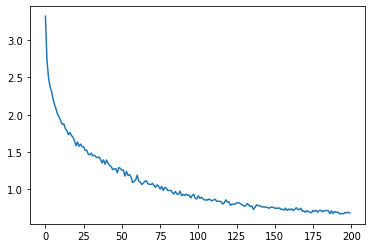

In [10]:
plt.figure()
plt.plot(all_losses)

In [316]:
max_length = 50

def sample(start_letter):
    with torch.no_grad():  
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        pattern = re.compile("asa[s|a]*")
        if pattern.match(output_name):
            output_name = sample(start_letter)
            
        output_name = output_name.title()
        
        output_name = re.sub("Iii","III",output_name)
        output_name = re.sub("Ii","II",output_name)
        output_name = re.sub("Iv","IV",output_name)

        return output_name


first_chars = [line[1] for line in lines]
first_char = random.sample(first_chars,1)[0]
print(sample(first_char))

Asta Bhejana
